In [1]:
""" Code example from Complexity and Computation, a book about
exploring complexity science with Python.  Available free from

http://greenteapress.com/complexity

Copyright 2016 Allen Downey
MIT License: http://opensource.org/licenses/MIT
"""
from __future__ import print_function, division

import sys

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation
from scipy.signal import convolve2d

"""
For animation to work in the notebook, you might have to install
ffmpeg.  On Ubuntu and Linux Mint, the following should work.

    sudo add-apt-repository ppa:mc3man/trusty-media
    sudo apt-get update
    sudo apt-get install ffmpeg
"""

class Cell2D:
    """Implements Conway's Game of Life."""

    def __init__(self, n, m=None):
        """Initializes the attributes.

        n: number of rows
        m: number of columns
        """
        m = n if m is None else m
        self.array = np.zeros((n, m), np.uint8)

    def add_cells(self, row, col, *strings):
        """Adds cells at the given location.

        row: top row index
        col: left col index
        strings: list of strings of 0s and 1s
        """
        for i, s in enumerate(strings):
            self.array[row+i, col:col+len(s)] = np.array([int(b) for b in s])

    def step(self):
        """Executes one time step."""
        pass


class Cell2DViewer:
    """Generates an animated view of an array image."""

    cmap = plt.get_cmap('Greens')
    options = dict(interpolation='nearest', alpha=0.8,
                   vmin=0, vmax=1)

    def __init__(self, viewee):
        self.viewee = viewee
        self.im = None
        self.hlines = None
        self.vlines = None

    # TODO: should this really take iters?
    def step(self, iters=1):
        """Advances the viewee the given number of steps."""
        for i in range(iters):
            self.viewee.step()

    def draw(self, grid=False):
        """Draws the array and any other elements.

        grid: boolean, whether to draw grid lines
        """
        self.draw_array(self.viewee.array)
        if grid:
            self.draw_grid()

    def draw_array(self, array=None, cmap=None, **kwds):
        """Draws the cells."""
        # Note: we have to make a copy because some implementations
        # of step perform updates in place.
        if array is None:
            array = self.viewee.array
        a = array.copy()
        cmap = self.cmap if cmap is None else cmap

        n, m = a.shape
        plt.axis([0, m, 0, n])
        plt.xticks([])
        plt.yticks([])

        options = self.options.copy()
        options['extent'] = [0, m, 0, n]
        options.update(kwds)
        self.im = plt.imshow(a, cmap, **options)

    def draw_grid(self):
        """Draws the grid."""
        a = self.viewee.array
        n, m = a.shape
        lw = 2 if m < 10 else 1
        options = dict(color='white', linewidth=lw)

        rows = np.arange(1, n)
        self.hlines = plt.hlines(rows, 0, m, **options)

        cols = np.arange(1, m)
        self.vlines = plt.vlines(cols, 0, n, **options)

    def animate(self, frames=20, interval=200, grid=False):
        """Creates an animation.

        frames: number of frames to draw
        interval: time between frames in ms
        """
        fig = plt.figure()
        self.draw(grid)
        anim = animation.FuncAnimation(fig, self.animate_func,
                                       init_func=self.init_func,
                                       frames=frames, interval=interval)
        return anim

    def init_func(self):
        """Called at the beginning of an animation."""
        pass

    def animate_func(self, i):
        """Draws one frame of the animation."""
        if i > 0:
            self.step()
        a = self.viewee.array
        self.im.set_array(a)
        return (self.im,)


0.58402668759811616

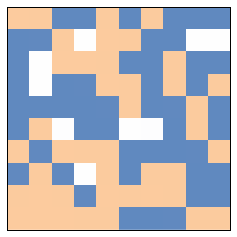

In [3]:
from __future__ import print_function, division

%matplotlib inline
#%precision 3

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

#import thinkplot
#from thinkstats2 import Cdf
#from thinkstats2 import RandomSeed

from matplotlib import rc
rc('animation', html='html5')

from Cell2D import Cell2D, Cell2DViewer

def locs_where(condition):
    """Find cells where a logical array is True.
    
    condition: logical array
    
    returns: array with one set of coordinates per row
    """
    return np.transpose(np.nonzero(condition))

from scipy.signal import correlate2d

class Schelling(Cell2D):
    """Represents a grid of Schelling agents."""
    
    options = dict(mode='same', boundary='wrap')

    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]], dtype=np.int8)
    
    def __init__(self, n, m=None, p=0.5):
        """Initializes the attributes.

        n: number of rows
        m: number of columns
        p: threshold on the fraction of similar neighbors
        """
        self.p = p
        m = n if m is None else m
        # 0 is empty, 1 is red, 2 is blue
        choices = [0, 1, 2]
        probs = [0.1, 0.45, 0.45]
        self.array = np.random.choice(choices, (n, m), p=probs).astype(np.int8)

    def count_neighbors(self):
        """Surveys neighboring cells.
        
        returns: tuple of (occupied, frac_red, frac_same)
        
        occupied: logical array indicating occupied cells
        frac_red: fraction of red neighbors around each cell
        frac_same: for each cell, the fraction of similar neighbors
        """
        a = self.array
        
        red = a==1
        blue = a==2
        occupied = a!=0

        # count red neighbors and all neighbors
        num_red = correlate2d(red, self.kernel, **self.options)
        num_neighbors = correlate2d(occupied, self.kernel, **self.options)

        # compute fraction of similar neighbors
        frac_red = num_red / num_neighbors
        frac_blue = 1 - frac_red
        frac_same = np.where(red, frac_red, frac_blue)
        
        # no neighbors is considered the same as no similar neighbors 
        frac_same[num_neighbors == 0] = 0
        frac_red[num_neighbors == 0] = 0
        
        return occupied, frac_red, frac_same

    def segregation(self):
        """Computes the average fraction of similar neighbors.
        
        returns: fraction of similar neighbors, averaged over cells
        """
        occupied, _, frac_same = self.count_neighbors()
        return np.sum(frac_same) / np.sum(occupied)
    
    def step(self):
        """Executes one time step.
                
        returns: fraction of similar neighbors, averaged over cells
        """
        a = self.array
        
        # find the unhappy cells
        occupied, _, frac_same = self.count_neighbors()
        unhappy_locs = locs_where(occupied & (frac_same < self.p))

        # find the empty cells
        empty = a==0
        num_empty = np.sum(empty)
        empty_locs = locs_where(empty)

        # shuffle the unhappy cells
        if len(unhappy_locs):
            np.random.shuffle(unhappy_locs)
            
        # for each unhappy cell, choose a random destination
        for source in unhappy_locs:
            i = np.random.randint(len(empty_locs))
            dest = tuple(empty_locs[i])

            # move
            a[dest] = a[tuple(source)]
            a[tuple(source)] = 0
            empty_locs[i] = source
        
        num_empty2 = np.sum(a==0)
        assert num_empty == num_empty2
        
        # return the average fraction of similar neighbors
        return np.sum(frac_same) / np.sum(occupied)

from matplotlib.colors import LinearSegmentedColormap

def make_cmap(color_dict, vmax=None, name='mycmap'):
    """Makes a custom color map.
    
    color_dict: map from numbers to colors
    vmax: high end of the range, 
    name: string name for map
    
    If vmax is None, uses the max value from color_dict
    
    returns: pyplot color map
    """
    if vmax is None:
        vmax = max(color_dict.keys())
    
    colors = [(value/vmax, color) for value, color in color_dict.items()]
    
    cmap = LinearSegmentedColormap.from_list(name, colors)
    
    return cmap


class SchellingViewer(Cell2DViewer):
    # colors from http://colorbrewer2.org/#type=qualitative&scheme=Accent&n=5
    colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0']
    cmap = make_cmap({0:'white', 1:colors[2], 2:colors[4]})
    options = dict(interpolation='none', alpha=0.8)

grid = Schelling(n=10)
viewer = SchellingViewer(grid)
viewer.draw()
grid.segregation()


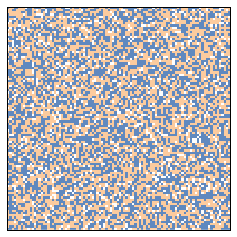

In [5]:
grid = Schelling(n=100)
viewer = SchellingViewer(grid)
anim = viewer.animate(frames=30)

0.53342803030303021

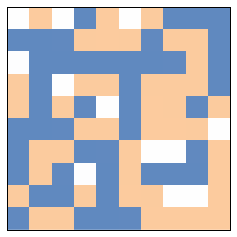

In [6]:
grid = Schelling(n=10)
viewer = SchellingViewer(grid)
viewer.draw()
grid.segregation()

0.6664096320346321

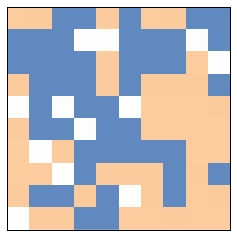

In [7]:
grid.step()
viewer = SchellingViewer(grid)
viewer.draw()
grid.segregation()

0.77180735930735933

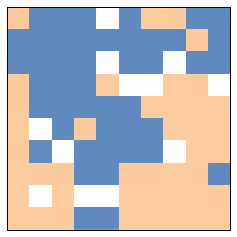

In [8]:
grid.step()
viewer = SchellingViewer(grid)
viewer.draw()
grid.segregation()